# Adversarial　Example -FGSM編-
AE(Adversarial Example)は機械学習のモデルに対する攻撃の一つ。これを行うことで、モデルの予測を誤らせることができる。なお、この攻撃はモデルが明らかになっている場合に行うことができる。

具体的な手法としては、損失関数を最大化させる方向に"入力データ"を調整する。

まずはライブラリのインポート

In [12]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets,transforms
import numpy as np
import matplotlib.pyplot as plt


ディレクトリの作成。事前に学習したモデルを取り込む。
``` bash
wget 'https://drive.google.com/uc?export=download&id=1KVOHbHnjCd1L-ookcd7CxDqb7rb8-DSx' -O './data/lenet_mnist_model.pth'
```

次に、画像に与える摂動の大きさεを定義する。このεは、0のときは元の画像のまま。大きいほどノイズが大きくなる。

In [13]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
pretrained_model = "data/lenet_mnist_model.pth"
use_cuda=True# cuda使いたくないとき、Falseにすると強制的にCPUで計算される

# MNISTモデルの定義
.pthファイルはモデルの重みを与えている。そのため、モデルの構造を定義する必要がある。

In [14]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
    
    def forward(self,x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

## データセットとデータローダーの定義

MNISTデータセットからデータローダーを作成する。
ここで、transforms.ToTensor()は勝手に0~1の範囲に変換してくれる。

In [15]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
    batch_size=1, shuffle=True)


device = torch.device("cuda" if (use_cuda and torch.cuda.is_available())else "cpu")

model = Net().to(device)

model.load_state_dict(torch.load(pretrained_model,map_location='cpu'))

model.eval()# 推論を有効に

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

## 攻撃するためのモデルの定義

$$attacked\_image=image+epsilon∗sign(data\_grad)=x+ϵ∗sign(∇x​J(θ,x,y))$$

元の画像に対して、最もロスが大きくなる方向に摂動を加える。

In [1]:
def fgsm_attack(image,epsilon,data_grad):
    
    sign_data_grad = data_grad.sign()#signは符号を返す
    attacked_image = image + epsilon*sign_data_grad
    attacked_image = torch.clamp(attacked_image,0,1)#clampは最大値と最小値を指定して、それを超えたら最大値と最小値にする

    return attacked_image


In [1]:
def test (model,device,test_loader,epsilon):

    # 精度を計算 
    correct = 0
    adv_examples = []
    
    # データローダーにあるデータを1つずつ取り出し、すべて用いる。
    for data,target in test_loader:
        data,target = data.to(device),target.to(device)
        data.requires_grad = True
        
        output = model(data)
        init_pred = output.max(1,keepdim=True)[1]# 最大値のインデックスを取得
        
        if init_pred.item() != target.item():# 予測が正しくない場合はスキップ(攻撃をしない)
            continue
        
        # 損失関数を計算と勾配を計算
        loss = F.nll_loss(output,target)
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data#入力値によるモデルの勾配を求めている

        # FGSM攻撃を実行
        attacked_data = fgsm_attack(data,epsilon,data_grad)

        # 攻撃後の画像を用いて、モデルを推論

        output = model(attacked_data)

        #精度の計算
        after_attack = output.max(1,keepdim=True)[1]
        if after_attack.item() == target.item():
            correct += 1
            if epsilon == 0:
                adv_ex = attacked_data.squeeze().detach().cpu().numpy()
                adv_examples.append((init_pred.item(),after_attack.item(),adv_ex))
        else:
            if len(adv_examples) < 5:
                adv_ex = attacked_data.squeeze().detach().cpu().numpy()
                adv_examples.append((init_pred.item(),after_attack.item(),adv_ex))
        
    after_accurate = correct/float(len(test_loader))

    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon,correct,len(test_loader),after_accurate))
    return after_accurate,adv_examples

## 攻撃をしてみよう

In [18]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 9810 / 10000 = 0.981
Epsilon: 0.05	Test Accuracy = 9426 / 10000 = 0.9426
Epsilon: 0.1	Test Accuracy = 8510 / 10000 = 0.851
Epsilon: 0.15	Test Accuracy = 6826 / 10000 = 0.6826
Epsilon: 0.2	Test Accuracy = 4301 / 10000 = 0.4301
Epsilon: 0.25	Test Accuracy = 2083 / 10000 = 0.2083
Epsilon: 0.3	Test Accuracy = 868 / 10000 = 0.0868


εと精度の関係

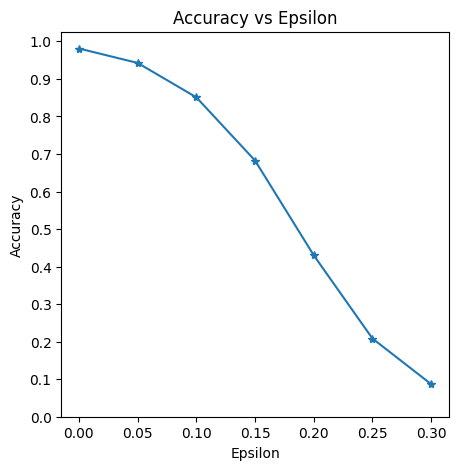

In [35]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.savefig(dpi = 300,fname = 'accuracy.png')
plt.show()

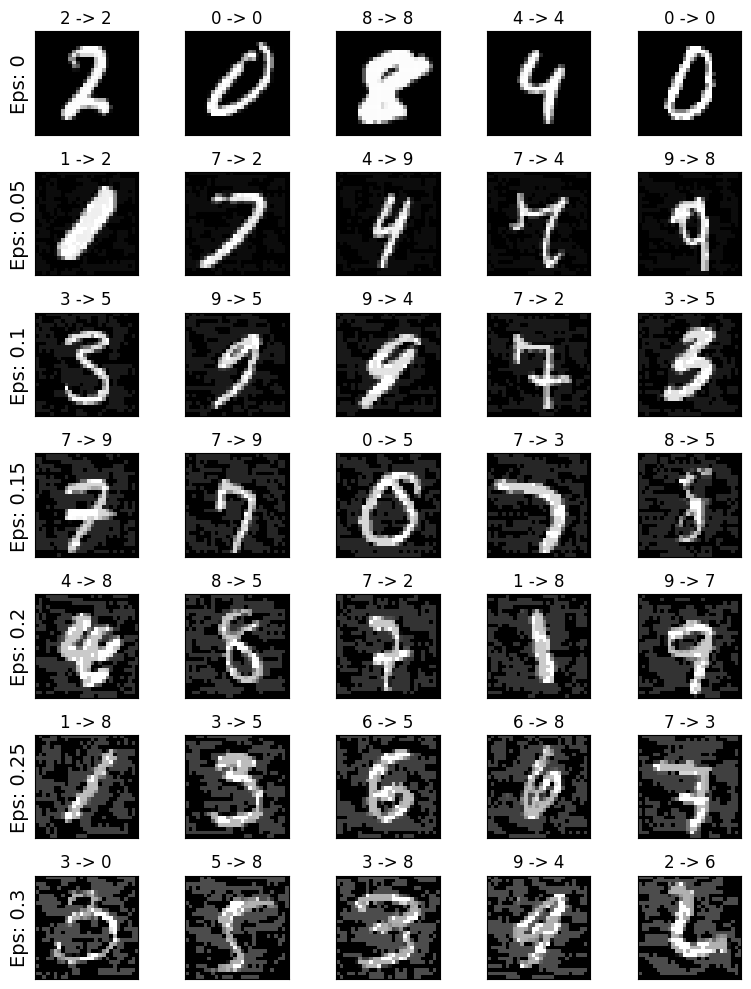

In [36]:
import matplotlib.pyplot as plt
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(5):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[1]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.savefig(dpi=300,format='png',fname='fgsm.png')
plt.show()